In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from statistics import mean
from IPython.display import clear_output
from datetime import datetime, timedelta
import time
pd.options.display.max_rows = 999

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plotea la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [3]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

initial_wallet_value = config['start_money']


In [4]:
# path = 'Mode_train-Model_gradient_boosting-TrainWw_480-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_10-RR_2-UseDaysClose_False'
# path = 'Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False'
# path = 'Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_3-SL_10-RR_3-UseDaysClose_False'
# path = 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_False'
# path = 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_4-UseDaysClose_False'

path = 'Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_7-UseDaysClose_False_noround'

orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))
wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))


In [5]:
orders.head(50)

,id,ticker,operation_type,open_time,close_time,open_price,last_price,close_price,profit,stop_loss,take_profit,units,profit_in_pips,comment
0,3e83e288-1fb1-11ef-8c85-c73def676cf0,EURUSD,OperationType.BUY,2023-01-02 18:00:00,2023-01-03 03:00:00,1.06554,1.06762,1.06562,0.40000,1.06562,1.07954,5000,0.00008,ClosePositionType.STOP_LOSS
1,404d1750-1fb1-11ef-959d-c73def676cf0,GBPUSD,OperationType.BUY,2023-01-03 10:00:00,2023-01-03 16:00:00,1.19123,1.19931,1.20523,70.02800,1.19731,1.20523,5002,0.01400,ClosePositionType.TAKE_PROFIT
2,42519e4c-1fb1-11ef-b97d-c73def676cf0,EURUSD,OperationType.SELL,2023-01-04 08:00:00,2023-01-04 09:00:00,1.05701,1.05701,1.05901,-10.70400,1.05901,1.04301,5352,-0.00200,ClosePositionType.STOP_LOSS
3,42519e4d-1fb1-11ef-ab27-c73def676cf0,USDJPY,OperationType.BUY,2023-01-04 08:00:00,2023-01-04 09:00:00,130.73000,130.73000,130.53000,-10.80000,130.53000,132.13000,54,-0.20000,ClosePositionType.STOP_LOSS
4,42520015-1fb1-11ef-ad10-c73def676cf0,AUDUSD,OperationType.SELL,2023-01-04 08:00:00,2023-01-04 09:00:00,0.68038,0.68038,0.68238,-10.70400,0.68238,0.66638,5352,-0.00200,ClosePositionType.STOP_LOSS
5,425a7ee8-1fb1-11ef-a7e8-c73def676cf0,GBPUSD,OperationType.SELL,2023-01-04 09:00:00,2023-01-04 10:00:00,1.20268,1.20268,1.20468,-10.70400,1.20468,1.18868,5352,-0.00200,ClosePositionType.STOP_LOSS
6,425b3842-1fb1-11ef-badb-c73def676cf0,USDCAD,OperationType.BUY,2023-01-04 09:00:00,2023-01-04 10:00:00,1.36189,1.36189,1.35989,-10.59800,1.35989,1.37589,5299,-0.00200,ClosePositionType.STOP_LOSS
7,42652b3f-1fb1-11ef-b3ba-c73def676cf0,USDJPY,OperationType.BUY,2023-01-04 10:00:00,2023-01-04 11:00:00,130.50000,130.50000,130.30000,-10.20000,130.30000,131.90000,51,-0.20000,ClosePositionType.STOP_LOSS
8,4265c451-1fb1-11ef-97ec-c73def676cf0,EURUSD,OperationType.SELL,2023-01-04 10:00:00,2023-01-04 16:00:00,1.06160,1.06045,1.06245,-4.32225,1.06245,1.04760,5085,-0.00085,ClosePositionType.STOP_LOSS
9,426f08c3-1fb1-11ef-91e6-c73def676cf0,GBPUSD,OperationType.SELL,2023-01-04 11:00:00,2023-01-04 12:00:00,1.20601,1.20601,1.20801,-10.06800,1.20801,1.19201,5034,-0.00200,ClosePositionType.STOP_LOSS


In [6]:
orders = orders.sort_values(by='close_time')

# Cantidad de compras y ventas

In [7]:
orders.operation_type.value_counts()

operation_type
OperationType.BUY     240
OperationType.SELL    204
Name: count, dtype: int64

# Cierres por SL y TP

In [8]:
orders.comment.value_counts()

comment
ClosePositionType.STOP_LOSS      435
ClosePositionType.TAKE_PROFIT      9
Name: count, dtype: int64

# Cierres por SL que terminaron positivos

In [9]:
orders[(orders['comment']=='ClosePositionType.STOP_LOSS') & (orders['profit']>=0)].shape[0] / orders[(orders['comment']=='ClosePositionType.STOP_LOSS')].shape[0]

0.3333333333333333

# Cierres por SL en que se minimizaron las perdidas

In [10]:
orders[(orders['comment']=='ClosePositionType.STOP_LOSS') & (orders['last_price']!=orders['open_price'])].shape[0] / orders[(orders['comment']=='ClosePositionType.STOP_LOSS')].shape[0]

0.6505747126436782

# Desempenio por ticker

In [11]:
orders_by_ticker = orders.groupby('ticker').agg(
    positivas=('profit', lambda x: (x > 0).sum()),
    negativas=('profit', lambda x: (x < 0).sum()),
    profit=('profit', lambda x: (x).sum()),
).reset_index()

orders_by_ticker['perc'] = (orders_by_ticker['positivas'] / (orders_by_ticker['positivas'] + orders_by_ticker['negativas'])) * 100
orders_by_ticker.sort_values(by='perc', ascending=False)

,ticker,positivas,negativas,profit,perc
4,USDCHF,29,37,287.87592,43.939394
2,GBPUSD,30,48,347.64571,38.461538
0,AUDUSD,25,43,-18.60232,36.764706
5,USDJPY,29,60,37.71400,32.584270
1,EURUSD,19,44,136.19663,30.158730
3,USDCAD,21,58,-216.73757,26.582278


# Rendimiento por mes

In [12]:
orders_per_month = orders[['close_time','profit', 'comment']].copy()
orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
orders_per_month['year'] = orders_per_month['close_time'].dt.year
orders_per_month['month'] = orders_per_month['close_time'].dt.month
orders_per_month['day'] = orders_per_month['close_time'].dt.day


orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
    amount_ops=('profit', 'count'),
    good_ops=('profit', lambda x: (x > 0).sum()),
    bad_ops=('profit', lambda x: (x < 0).sum()),
    take_profit=('comment', lambda x: (x == 'ClosePositionType.TAKE_PROFIT').sum()),
    stop_loss=('comment', lambda x: (x == 'ClosePositionType.STOP_LOSS').sum()),
    profit_sum=('profit', 'sum'),
    max_profit=('profit', 'max'),

).reset_index()

orders_per_month_gb = pd.concat([
    pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
    orders_per_month_gb
])

orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()

orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))

orders_per_month_gb['perc_change'] = orders_per_month_gb['perc_change'].round(3)

orders_per_month_gb['perc_good_ops'] = (orders_per_month_gb['good_ops'] / orders_per_month_gb['amount_ops'])

orders_per_month_gb[[
    'year', 
    'month', 
    'amount_ops', 
    'take_profit',
    'stop_loss',
    'good_ops', 
    'bad_ops',
    'perc_good_ops',
    'max_profit', 
    'profit_sum', 
    'profit_cumsum', 
    'perc_change', 
]].round(3)

,year,month,amount_ops,take_profit,stop_loss,good_ops,bad_ops,perc_good_ops,max_profit,profit_sum,profit_cumsum,perc_change
0,2023,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1000.000,1000.000,NaN
0,2023,1,45,2.0,43.0,19.0,26.0,0.422,77.000,293.605,1293.605,0.294
1,2023,2,73,2.0,71.0,20.0,53.0,0.274,89.600,-36.626,1256.979,-0.028
2,2023,3,68,3.0,65.0,21.0,47.0,0.309,102.200,116.944,1373.923,0.093
3,2023,4,32,0.0,32.0,13.0,19.0,0.406,60.778,116.481,1490.404,0.085
4,2023,5,33,0.0,33.0,12.0,21.0,0.364,38.012,-78.363,1412.040,-0.053
5,2023,6,37,0.0,37.0,10.0,27.0,0.270,55.758,-63.724,1348.317,-0.045
6,2023,7,31,1.0,30.0,13.0,18.0,0.419,96.474,154.938,1503.255,0.115
7,2023,8,25,0.0,25.0,10.0,14.0,0.400,33.332,-7.218,1496.037,-0.005
8,2023,9,19,0.0,19.0,6.0,13.0,0.316,62.083,-69.152,1426.885,-0.046


In [13]:
orders_per_month_gb.perc_change.mean()

0.042833333333333334

In [14]:
orders_per_month_gb.perc_change.std()

0.10213968450859416

In [15]:
change_percent = orders_per_month_gb.perc_change.reset_index().copy().drop(columns='index')
change_percent.fillna(0, inplace=True)

# Inicializar el valor de partida
initial_value = 5000

# Crear una columna para la suma acumulada
change_percent['cumulative_sum'] = initial_value

# Calcular la suma acumulada basada en los porcentajes
for i in range(1, len(change_percent)):
    change_percent.loc[i, 'cumulative_sum'] = change_percent.loc[i-1, 'cumulative_sum'] * (1 + change_percent.loc[i, 'perc_change'])

change_percent

,perc_change,cumulative_sum
0,0.000,5000.000000
1,0.294,6470.000000
2,-0.028,6288.840000
3,0.093,6873.702120
4,0.085,7457.966800
5,-0.053,7062.694560
6,-0.045,6744.873305
7,0.115,7520.533735
8,-0.005,7482.931066
9,-0.046,7138.716237


# Rendimiento por dia

In [16]:
orders_per_month_gb = orders_per_month.groupby(by=['year','month', 'day']).agg(
    amount_ops=('profit', 'count'),
    good_ops=('profit', lambda x: (x > 0).sum()),
    bad_ops=('profit', lambda x: (x < 0).sum()),
    take_profit=('comment', lambda x: (x == 'ClosePositionType.TAKE_PROFIT').sum()),
    stop_loss=('comment', lambda x: (x == 'ClosePositionType.STOP_LOSS').sum()),
    profit_sum=('profit', 'sum'),
    max_profit=('profit', 'max'),

).reset_index()

orders_per_month_gb = pd.concat([
    pd.DataFrame({'year':[2023], 'month':[0], 'day':[0], 'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
    orders_per_month_gb
])

orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()

orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'])

orders_per_month_gb['perc_change'] = orders_per_month_gb['perc_change'].round(3)

orders_per_month_gb['perc_good_ops'] = (orders_per_month_gb['good_ops'] / orders_per_month_gb['amount_ops']) * 100

orders_per_month_gb = orders_per_month_gb[[
    'year', 
    'month', 
    'amount_ops', 
    'take_profit',
    'stop_loss',
    'good_ops', 
    'bad_ops',
    'perc_good_ops',
    'max_profit', 
    'profit_sum', 
    'profit_cumsum', 
    'perc_change', 
]].round(3)

orders_per_month_gb[orders_per_month_gb['month']==2]

,year,month,amount_ops,take_profit,stop_loss,good_ops,bad_ops,perc_good_ops,max_profit,profit_sum,profit_cumsum,perc_change
18,2023,2,1,0.0,1.0,0.0,1.0,0.000,-13.000,-13.000,1280.605,-0.010
19,2023,2,6,1.0,5.0,3.0,3.0,50.000,89.600,80.075,1360.680,0.059
20,2023,2,14,1.0,13.0,3.0,11.0,21.429,88.914,-0.982,1359.698,-0.001
21,2023,2,16,0.0,16.0,6.0,10.0,37.500,42.907,-5.899,1353.800,-0.004
22,2023,2,1,0.0,1.0,1.0,0.0,100.000,13.064,13.064,1366.864,0.010
23,2023,2,1,0.0,1.0,0.0,1.0,0.000,-11.276,-11.276,1355.588,-0.008
24,2023,2,4,0.0,4.0,1.0,3.0,25.000,30.298,-1.348,1354.239,-0.001
25,2023,2,4,0.0,4.0,1.0,3.0,25.000,30.714,-4.902,1349.337,-0.004
26,2023,2,1,0.0,1.0,1.0,0.0,100.000,1.552,1.552,1350.889,0.001
27,2023,2,5,0.0,5.0,1.0,4.0,20.000,14.048,-33.453,1317.436,-0.025


In [17]:
# ticker = 'GBPUSD'
# date_from = datetime(2023,1,1)
# date_to = date_from + timedelta(days=15)

# while date_to < datetime(2024,1,1):
#     date_from_str = date_from.strftime('%Y-%m-%d')
#     date_to_str = date_to.strftime('%Y-%m-%d')

#     historical_prices = pd.read_csv(f'./backbone/data/backtest/symbols/{ticker}.csv')
    
#     historical_prices = historical_prices[
#         (historical_prices['Date']>date_from_str)
#         & (historical_prices['Date']<date_to_str)
#     ]
    
#     plt.figure(figsize=(14, 7))
#     plt.plot(historical_prices['Date'], historical_prices['Close'], label='EURUSD Price', color='blue')
    
#     # Añadir las operaciones de compra y venta
#     buy_trades = orders[
#         (orders['operation_type']=='OperationType.BUY') 
#         & (orders['close_time']>date_from_str)
#         & (orders['close_time']<date_to_str)
#         & (orders['ticker']==ticker)
#     ]
#     sell_trades = orders[
#         (orders['operation_type']=='OperationType.SELL') 
#         & (orders['close_time']>date_from_str)
#         & (orders['close_time']<date_to_str)
#         & (orders['ticker']==ticker)
#     ]
    
#     # Graficar las operaciones de compra
#     plt.scatter(buy_trades['open_time'], buy_trades['open_price'], color='green', marker='^', s=100, label='Buy Open')
#     plt.scatter(buy_trades['close_time'], buy_trades['close_price'], color='lime', marker='o', s=100, label='Buy Close')
    
#     # Graficar las operaciones de venta
#     plt.scatter(sell_trades['open_time'], sell_trades['open_price'], color='red', marker='v', s=100, label='Sell Open')
#     plt.scatter(sell_trades['close_time'], sell_trades['close_price'], color='orange', marker='o', s=100, label='Sell Close')
    
#     # Añadir etiquetas y leyenda
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.title('EURUSD Price with Buy/Sell Trades')
#     plt.legend()
    
#     # Mostrar el gráfico
#     plt.show()
    
#     print(date_from_str, date_to_str)
   
#     time.sleep(8)
#     clear_output(wait=True)

#     date_from += timedelta(days=7)
#     date_to = date_from + timedelta(days=15)


In [18]:
orders_per_month = orders[['close_time','comment', 'ticker', 'profit']].copy()
orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
orders_per_month['year'] = orders_per_month['close_time'].dt.year
orders_per_month['month'] = orders_per_month['close_time'].dt.month
orders_per_month['day'] = orders_per_month['close_time'].dt.day

orders_per_month_gb = orders_per_month.groupby(by=['year','month', 'day']).agg(
    take_profit=('comment', lambda x: (x == 'ClosePositionType.TAKE_PROFIT').sum()),
    stop_loss=('comment', lambda x: (x == 'ClosePositionType.STOP_LOSS').sum()),
    profit=('profit', lambda x: (x).sum()),

)

orders_per_month_gb['tp_cumsum'] = orders_per_month_gb.groupby(by=['year','month'])['take_profit'].cumsum()
orders_per_month_gb['sl_cumsum'] = orders_per_month_gb.groupby(by=['year','month'])['stop_loss'].cumsum()
orders_per_month_gb['profit_cumsum'] = orders_per_month_gb.groupby(by=['year','month'])['profit'].cumsum()
orders_per_month_gb

take_profit  stop_loss     profit  tp_cumsum  sl_cumsum  \
year month day                                                            
2023 1     3              1          1   70.42800          1          1   
           4              0         10  -93.59738          1         11   
           5              0          5  160.79768          1         16   
           6              0          2   39.58284          1         18   
           9              0          1  -11.80000          1         19   
           11             0          1    8.44915          1         20   
           12             0          2  -20.45000          1         22   
           13             0          7  -47.16901          1         29   
           16             0          1  -11.06200          1         30   
           18             0          3  -18.84700          1         33   
           19             0          1   25.00200          1         34   
           23             1          1   65.21600          2         35   
           24             0          2   97.41110          2         37   
           25             0          1  -12.45040          2         38   
           26             0          2   -8.19798          2         40   
           27             0          1   -5.47096          2         41   
           30             0          1    1.79481          2         42   
           31             0          1   53.96808          2         43   
     2     1              0          1  -13.00000          0          1   
           3              1          5   80.07544          1          6   
           6              1         13   -0.98192          2         19   
           7              0         16   -5.89889          2         35   
           8              0          1   13.06417          2         36   
           9              0          1  -11.27610          2         37   
           13             0          4   -1.34814          2         41   
           14             0          4   -4.90243          2         45   
           15             0          1    1.55181          2         46   
           16             0          5  -33.45293          2         51   
           17             0          3  -33.91066          2         54   
           20             0          1   51.27262          2         55   
           21             0          6   10.06818          2         61   
           22             0          1   -8.80844          2         62   
           27             0          3  -39.81200          2         65   
           28             0          6  -39.26668          2         71   
     3     1              1          8   64.13513          1          8   
           2              0          7   24.07245          1         15   
           3              0          4    1.11834          1         19   
           6              0          1  -13.46400          1         20   
           7              0          2   12.85676          1         22   
           8              1          3   75.62116          2         25   
           10             1          5  107.74644          3         30   
           13             0          2  -30.40000          3         32   
           14             0          3   -6.32754          3         35   
           15             0          4    9.55288          3         39   
           16             0          2  -16.56114          3         41   
           17             0          2   21.76111          3         43   
           21             0          1  -15.07000          3         44   
           22             0          1  -10.51860          3         45   
           24             0          4  -12.60498          3         49   
           27             0          4  -32.95848          3         53   
           28             0          4   10.65116          3         57   
           29             0          4  -

# Que hubiera pasado si no se operaba con algunos tickers?

In [19]:
# tickers_permitidos = orders_by_ticker[orders_by_ticker['profit']>0].ticker.unique()
# print(tickers_permitidos)

tickers_permitidos = [
    'EURUSD', 
    'GBPUSD', 
    'USDJPY', 
    'USDCAD', 
    'AUDUSD', 
    'USDCHF'
]

orders_min = orders_per_month[orders_per_month['ticker'].isin(tickers_permitidos)].copy().reset_index()

# Rendimiento por mes

In [20]:
orders_per_month_gb = orders_min.groupby(by=['year','month']).agg(
    amount_ops=('profit', 'count'),
    good_ops=('profit', lambda x: (x > 0).sum()),
    bad_ops=('profit', lambda x: (x < 0).sum()),
    profit_sum=('profit', 'sum'),

).reset_index()

orders_per_month_gb = pd.concat([
    pd.DataFrame({'year':[2023], 'month':[0], 'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
    orders_per_month_gb
])

orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()

orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'])

orders_per_month_gb['perc_change'] = orders_per_month_gb['perc_change'].round(3)

orders_per_month_gb['perc_good_ops'] = (orders_per_month_gb['good_ops'] / orders_per_month_gb['amount_ops']) * 100

orders_per_month_gb = orders_per_month_gb[[
    'year', 
    'month', 
    'amount_ops', 
    'good_ops', 
    'bad_ops',
    'perc_good_ops',
    'profit_sum', 
    'profit_cumsum', 
    'perc_change', 
]].round(3)
orders_per_month_gb

,year,month,amount_ops,good_ops,bad_ops,perc_good_ops,profit_sum,profit_cumsum,perc_change
0,2023,0,0,NaN,NaN,NaN,1000.000,1000.000,NaN
0,2023,1,45,19.0,26.0,42.222,293.605,1293.605,0.227
1,2023,2,73,20.0,53.0,27.397,-36.626,1256.979,-0.029
2,2023,3,68,21.0,47.0,30.882,116.944,1373.923,0.085
3,2023,4,32,13.0,19.0,40.625,116.481,1490.404,0.078
4,2023,5,33,12.0,21.0,36.364,-78.363,1412.040,-0.055
5,2023,6,37,10.0,27.0,27.027,-63.724,1348.317,-0.047
6,2023,7,31,13.0,18.0,41.935,154.938,1503.255,0.103
7,2023,8,25,10.0,14.0,40.000,-7.218,1496.037,-0.005
8,2023,9,19,6.0,13.0,31.579,-69.152,1426.885,-0.048


In [21]:
orders_min['wallet'] = orders_min['profit']
orders_min.loc[0, 'wallet'] = initial_wallet_value + orders_min.iloc[0]['profit']
orders_min['wallet'] = orders_min['wallet'].cumsum()

In [22]:
orders_by_ticker = orders_min.groupby('ticker').agg(
    positivas=('profit', lambda x: (x > 0).sum()),
    negativas=('profit', lambda x: (x < 0).sum()),
    profit=('profit', lambda x: (x).sum()),
).reset_index()

orders_by_ticker['perc'] = orders_by_ticker['positivas'] / (orders_by_ticker['positivas'] + orders_by_ticker['negativas'])
orders_by_ticker.sort_values(by='perc', ascending=False)

,ticker,positivas,negativas,profit,perc
4,USDCHF,29,37,287.87592,0.439394
2,GBPUSD,30,48,347.64571,0.384615
0,AUDUSD,25,43,-18.60232,0.367647
5,USDJPY,29,60,37.71400,0.325843
1,EURUSD,19,44,136.19663,0.301587
3,USDCAD,21,58,-216.73757,0.265823


In [23]:
orders_min[(orders_min['comment']=='ClosePositionType.STOP_LOSS') & (orders_min['profit']>=0)].shape[0] / orders_min[(orders_min['comment']=='ClosePositionType.STOP_LOSS')].shape[0]

0.3333333333333333

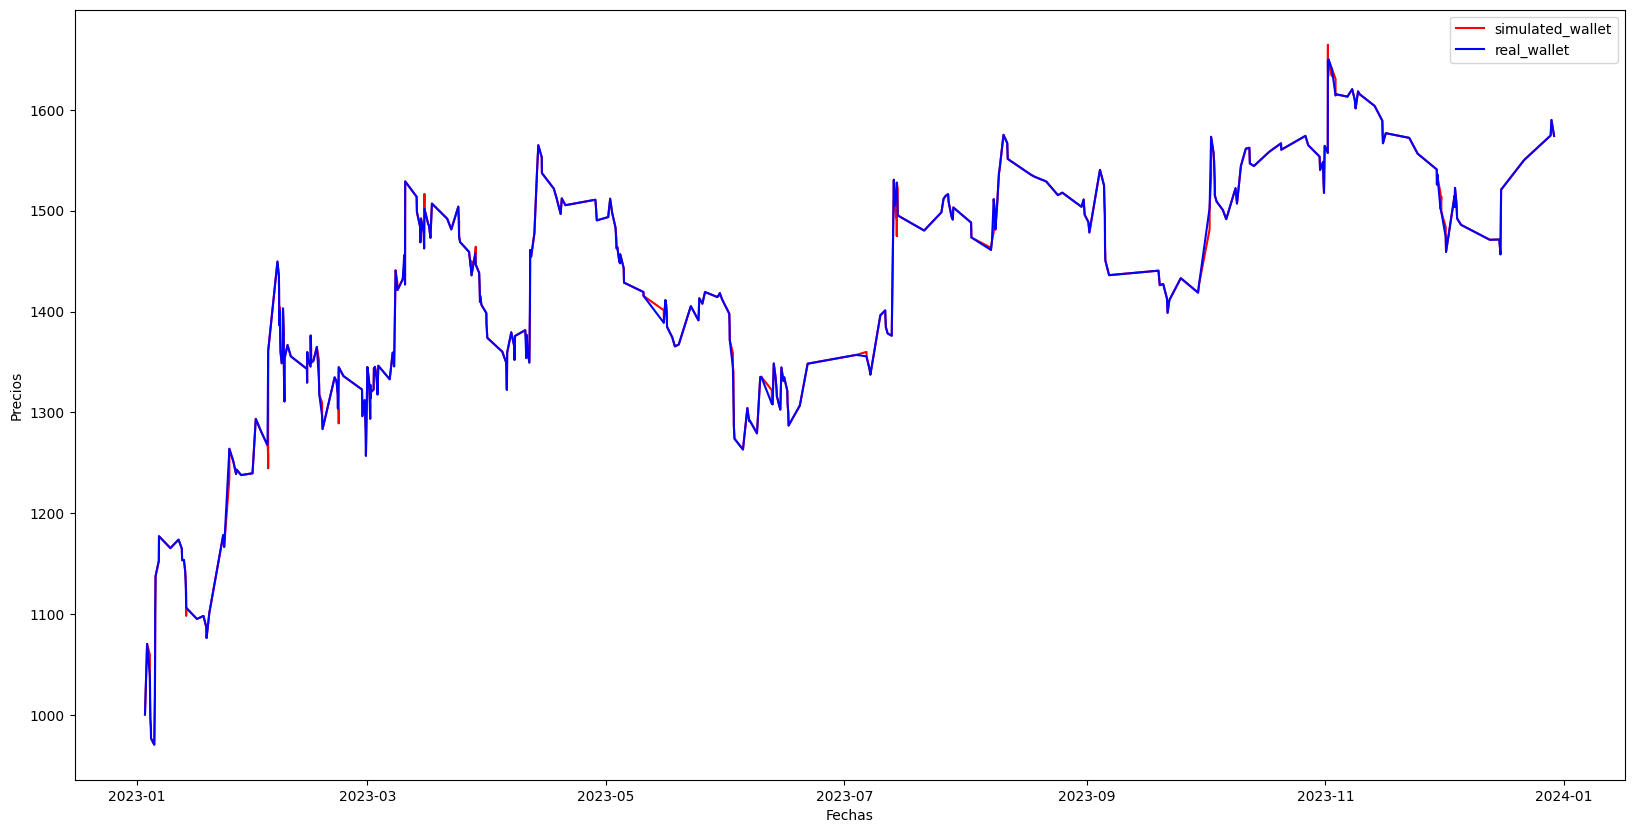

In [24]:
import matplotlib.pyplot as plt
import numpy as np


# Datos de ejemplo
x_wallet = pd.to_datetime(orders_min['close_time'])
y_wallet = orders_min['wallet']  # Datos para la línea
# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))
# Agregar la línea
ax.plot(x_wallet, y_wallet, label='simulated_wallet', color='red')



# Datos de ejemplo
x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea
# Crear una figura y ejes
# Agregar la línea
ax.plot(x_wallet, y_wallet, label='real_wallet', color='blue')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


In [25]:
predictions

NameError: name 'predictions' is not defined

In [ ]:
true_values = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'trainres.csv'))
predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'test_res.csv'))

In [ ]:
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, classification_report


precision = precision_score(predictions.y_true, predictions.y_pred, average='weighted')
recall = recall_score(predictions.y_true, predictions.y_pred, average='weighted')
f1 = f1_score(predictions.y_true, predictions.y_pred, average='weighted')

print(precision)
print(recall)
print(f1)

In [ ]:
print(classification_report(predictions['y_true'], predictions['y_pred']))

In [ ]:


from sklearn.metrics import precision_score, f1_score, recall_score



tickers = config["tickers"] 
tickers

predictions = predictions.sort_values(by='fecha')
true_values = true_values.sort_values(by='fecha')


# renombro las columnas
column_names = {}
for column in predictions.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_preds'

predictions = predictions.rename(columns=column_names)

column_names = {}
for column in true_values.columns:
    if column != 'fecha':
        column_names[column] = f'{column}_true'

true_values = true_values.rename(columns=column_names)
performance = pd.concat(
    [
        predictions,
        true_values
    ], axis=1, join="inner"
)

recall_list = []
f1_list = []
precision_list = []

for ticker in tickers:
    y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
    y_pred = performance[performance[f'{ticker}_preds'].notna()][f'{ticker}_preds']
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # print(classification_report(performance[f'{ticker}_true'], performance[f'{ticker}_preds'], target_names=target_names))
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    

# Grafico de velas

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Candlestick(x=prices['Date'],
#                 open=prices['Open'],
#                 high=prices['High'],
#                 low=prices['Low'],
#                 close=prices['Close'])])

# fig.update_layout(
#     title=f"{config['ticker']}",
#     yaxis_title=f"{config['ticker']} Stock"
# )

# fig.show()

# Estrategia

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['fecha'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

x_wallet = pd.to_datetime(wallet['date'])
y_wallet = wallet['wallet']  # Datos para la línea

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

ax.plot(x_wallet, y_wallet, label='wallet', color='purple')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x_prices = pd.to_datetime(prices['Date'])
y_prices = prices['Close']  # Datos para la línea

x_buy = pd.to_datetime(buys['date'])
y_buy = buys['buy']  # Datos para el scatter plot

x_sell = pd.to_datetime(sells['date'])
y_sell = sells['sell']  # Datos para el scatter plot

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='market', color='black')

# Agregar el scatter plot
ax.scatter(x_buy, y_buy, label='compras', color='cyan', marker='>')

ax.scatter(x_sell, y_sell, label='Ventas', color='red', marker='o')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

print('Area bajo la curva: ', auc(wallet.index, wallet['wallet']))

# Datos de ejemplo
x_prices = pd.to_datetime(wallet['date'])
y_prices = wallet['wallet']  # Datos para la línea


# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Agregar la línea
ax.plot(x_prices, y_prices, label='Wallet', color='blue')

# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()

# Mostrar el gráfico
plt.show()


# Modelo

In [ ]:
predictions.sort_values(by='fecha')

In [ ]:
true_values.sort_values(by='fecha')

In [ ]:
accuracy_score(predictions[predictions['YPF'].notna()].YPF, true_values[true_values['YPF'].notna()].YPF)

In [ ]:
threshold_down = 0.5
threshold_up = 0.5

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
threshold_down = 0.1
threshold_up = 0.9

df_predictions = performance[(performance['y_pred']<threshold_down) | (performance['y_pred']>threshold_up)].copy()
df_predictions['y_pred'] = np.where(df_predictions['y_pred']<threshold_down, 0, df_predictions['y_pred'])
df_predictions['y_pred'] = np.where(df_predictions['y_pred']>threshold_up, 1, df_predictions['y_pred'])

print(accuracy_score(df_predictions.y_true, df_predictions.y_pred))
plot_confusion_matrix(df_predictions.y_true, df_predictions.y_pred, classes=[0,1], cmap=plt.cm.Reds)

In [ ]:
plt.hist(performance.y_pred, color='lightgreen', ec='black', bins=50)
plt.show()

In [ ]:
buys = buys.rename(columns={''})

In [ ]:
operations = pd.concat([buys[buys['YPF'].notna()], sells[sells['YPF'].notna()]], axis=1, join="inner")[['fecha','YPF']]
operations

In [ ]:
operations['positive'] = np.where(operations['buy']>operations['sell'], 0, 1)
operations['Profit'] = operations['sell'] - operations['buy'] 
operations['positive'].value_counts()